# NumPy Based CNN block (10 points)

##   Outline of the Assignment

You will be implementing the building blocks of a convolutional neural network

1. **`zero padding`**

2. **`convolution : Forward`**

3. **`convolution : Backward`**

4. **`Max pooling : Forward`**

5. **`Max pooling : Backward`**


    
This notebook will ask you to implement these functions from scratch in **`Numpy`**.


**Note** that for every forward function, there is its corresponding backward equivalent. 

In [1]:
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 1. Zero Padding (1 pts.)

Zero-padding adds zeros around the border of an image:

**Exercise**  : Implement the following function, which pads all the images of a batch of examples X with zeros.

shape of X and its zero pad array is :


$$ X : (N, C, i_h, i_w)   $$
$$  \text{zeropad}(X) : (N, C, i_h + 2*ph, i_w + 2*pw)$$

**Note** : you should not use np.pad in your implementation

In [69]:
def zero_padding(X, padding):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image.

    input :
      - X :  numpy array of shape (N, C, IH, IW) representing a batch of N images
      - padding : a tuple of 2 integer (ph, pw), amount of padding around each image on vertical and horizontal dimensions
    return :
      - zero_pad : zero pad array of shape (N, C, IH + 2*ph, IW + 2*pw)
    
    """
  
    zero_pad = None
    ###########################################################################
    # Hint: you should not use the function np.pad for padding.                     
    ###########################################################################
    pad_h, pad_w = padding

    padded_shape = list(X.shape)
    padded_shape[2] += 2 * pad_h
    padded_shape[3] += 2 * pad_w

    zero_pad = np.zeros(padded_shape, dtype=X.dtype)
    
    if pad_h == 0:
        if pad_w == 0:
            zero_pad[:, :, :, :] = X
        else:
            zero_pad[:, :, :, pad_w:-pad_w] = X
    else:
        if pad_w == 0:
            zero_pad[:, :, pad_h:-pad_h, :] = X
        else:
            zero_pad[:, :, pad_h:-pad_h, pad_w:-pad_w] = X
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return zero_pad
    
    
    

your implementation is correct
shape of x is : (2, 3, 4, 4)
shape of x_pad is : (2, 3, 10, 8)


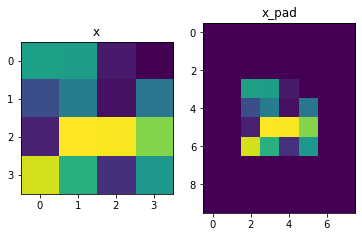

In [63]:
#test zero_padding function
np.random.seed(1968)

x = np.random.rand(2, 3 ,4, 4)
padding = (3, 2)
x_pad = zero_padding(x, padding)


assert x_pad.shape==(x.shape[0], x.shape[1], x.shape[2] + 2*padding[0], x.shape[3] + 2*padding[1])
assert np.all(x_pad[:, :, padding[0]:padding[0]+x.shape[2], padding[1]:padding[1]+x.shape[3]]==x)

print("your implementation is correct")
print("shape of x is :", x.shape)
print("shape of x_pad is :", x_pad.shape)

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0, 0, :, :])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0, 0, :, :])

## 2.convolution : Forward (2 pts.)

In this Exercise, you implement convolutional neural networks using the NumPy library only.

The input X,W are the input of the convolutional layer and the shape of X,W are $(N, C, i_h, i_w)$ , $(F, C, f_h, f_w)$ respectively and The return  value O is the output of the convolutional layer and the shape is $(N, F, O_h, O_w)$ where :

$$\text{stride} : (s_h,s_w)$$

$$\text{padding} : (p_h,p_w)$$

$$O_w =\lfloor \frac{i_w - f_w + 2*p_w}{s_w} \rfloor + 1$$

$$O_h = \lfloor\frac{i_h - f_h + 2*p_h}{s_h}\rfloor + 1$$
$$O(b,f, i ,j)=\sum_{r=0}^{C-1}\sum_{k=0}^{f_h-1}\sum_{l=0}^{f_w-1} W(f,r,k,l) X(b,r,s_h *i +k, s_w  *j +l)$$

In [51]:
def convolution2D(X, W, stride, padding):
    """
    A implementation of the forward pass for a convolutional layer.
    
    The input consists of N data points, each with C channels, height IH and
    width IW .We convolve each input with F different filters, where each filter
    spans all C channels and has height FH and width FW.
    
    
    inputs:
     - X : input data of shape (N, C, IH, IW)
     - W : Filter weight of shape (F, C, FH, FW)
     - stride : a tuple of 2 integer (sh, sw)
     - padding :a tuple of 2 integer (ph, pw)
     
    return:
     - out : Output data, of shape (N, F, OH, OW) where OH and OW given by
     
     OH= 1 + int ( (IH + 2*ph - FH)/ sh )
     OW= 1 + int ( (IW + 2*pw - FW)/ sw )
    
    """
    
    out = None
    ###########################################################################
    # Implement the convolutional forward pass.                               #
    ###########################################################################
    (N, C_in, IH, IW) = X.shape
    (F, C_wt, FH, FW) = W.shape
    assert C_in == C_wt, f"Number of input channels ({C_in}) not equal to number of channels in filters ({C_wt})"
    C = C_in
    
    # get striding and padding parameters
    (sh, sw) = stride
    (ph, pw) = padding
    
    
    # pad the input
    X_pad = zero_padding(X, padding)
    
    # compute dimensions of the output
    OH = 1 + int((IH + 2*ph - FH)/ sh)
    OW = 1 + int((IW + 2*pw - FW)/ sw)
    out = np.zeros((N, F, OH, OW), dtype=X.dtype)
    
    # get striding indices
    h_indices = np.arange(0, X_pad.shape[2] - FH + 1, sh)
    w_indices = np.arange(0, X_pad.shape[3] - FW + 1, sw)
    assert len(h_indices) == OH and np.max(h_indices) < X_pad.shape[2]
    assert len(w_indices) == OW and np.max(w_indices) < X_pad.shape[3]
    
    import itertools 
    stride_indices = [i for i in itertools.product(h_indices, w_indices)]
    output_indices = [i for i in itertools.product(np.arange(0, OH), np.arange(0, OW))]    
    assert len(stride_indices) == len(output_indices)
    
    # loop over filters
    for f in range(F):
        W_filter = W[f]
        W_filter = np.repeat(np.expand_dims(W_filter, 0), N, axis=0)
        
        for i, (h, w) in enumerate(stride_indices):
            (h_out, w_out) = output_indices[i]
            X_filter = X_pad[:, :, h:h+FH, w:w+FW]
            
            # compute dot product between (C, H, W) and (C, H, W) for each sample
            out[:, f, h_out, w_out] = np.einsum("NFHW,NFHW->N", X_filter, W_filter)
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return out

In [52]:
import time
import torch
import torch.nn as nn

np.random.seed(1973)
X = np.random.rand(2, 3, 23, 20).astype(np.float32)
W = np.random.rand(7, 3, 6, 6).astype(np.float32)
param1 = {'X':X, 'W':W, 'stride':(3, 6), 'padding':(2, 3)}
start = time.time()
conv_numpy = convolution2D(**param1)
end = time.time()
print(f"Compute time (NumPy): {end - start}")

conv2d = nn.Conv2d(in_channels=3, out_channels=7, kernel_size=(6, 6), stride=(3, 6), padding=(2, 3))
conv2d.weight.data = torch.from_numpy(W).float()
conv2d.weight.requires_grad = False
conv2d.bias.data = torch.zeros_like(conv2d.bias.data).float()
conv2d.bias.requires_grad = False
torch_X = torch.from_numpy(X).float()
start = time.time()
conv_torch = conv2d(torch_X)
end = time.time()
print(f"Compute time (PyTorch): {end - start}")

error = np.sum(conv_numpy - conv_torch.numpy())**2

print("Output shape: ", conv_numpy.shape)
print("Error: ", error)

Compute time (NumPy): 0.003905057907104492
Compute time (PyTorch): 0.0003342628479003906
Output shape:  (2, 7, 8, 4)
Error:  1.6575540939811617e-10


In [53]:
import torch
np.random.seed(1973)
param1 = {'X':np.random.rand(2, 3, 23, 20), 'W':np.random.rand(7, 3, 6, 6), 'stride':(3, 6), 'padding':(2, 3)}
x_tf = np.pad(param1['X'], ((0, 0), (0, 0), (2, 2), (3, 3)), 'constant', constant_values=0)
conv_pytorch = torch.nn.Conv2d(3, 7, kernel_size=(6, 6), stride=param1['stride'], padding=param1['padding'], bias=False)
conv_pytorch.weight = torch.nn.Parameter(torch.from_numpy(param1['W']))
X_t = torch.tensor(param1['X'])
assert conv_pytorch.forward(X_t).detach().numpy().shape == convolution2D(**param1).shape, "Shape Mismatch"
assert np.allclose(conv_pytorch.forward(X_t).detach().numpy(), convolution2D(**param1)), "Error in computing convolution"

To test your implementation, we will compare the results  with tensorflow function

In [54]:
# np.random.seed(1973)
# param1 = {'X':np.random.rand(2, 3, 23, 20), 'W':np.random.rand(7, 3, 6, 6), 'stride':(3, 6), 'padding':(2, 3)}
# x_tf = np.pad(param1['X'], ((0, 0), (0, 0), (2, 2), (3, 3)), 'constant', constant_values=0)


# conv_numpy = convolution2D(**param1)
# conv = tf.nn.conv2d(tf.transpose(x_tf, [0 ,2, 3, 1]), tf.transpose(param1['W'], (2, 3, 1, 0)), [1, 3, 6, 1], 'VALID')
# conv = tf.transpose(conv, (0, 3, 1, 2))

# with tf.Session() as sess:
#     conv = sess.run(conv)


# assert conv.shape==conv_numpy.shape
# print("Error :", (np.sum(conv - conv_numpy)**2))
# print("output shape :", conv_numpy.shape)


** Expected Output: **
<table>
    <tr>
        <td>
            **out shape**
        </td>
        <td>
            (2, 7, 8, 4)
        </td>
    </tr>
    <tr>
        <td>
            **ERROR**
        </td>
        <td>
            2.5559093329160782e-28
       </td>
    </tr>
    
</table>


## 3.convolution : Backward

### 3.1 - Backward  w.r.t. filter (3 pts.)

This is the formula for computing a $\frac{\partial L}{\partial W}$ for a single $W(f^\prime,c^\prime,k^\prime ,l^\prime )$ that $W$ is 4-D array as a filter in convolution operation with shape $(F,C,f_h,f_w)$ 

$$\frac{\partial L}{\partial W(f^\prime,c^\prime,k^\prime ,l^\prime )} = \sum_{b=0}^{N-1}\left (\sum_{i=0}^{O_h-1}\sum_{j=0}^{O_w-1} \frac{\partial L}{\partial O(b,f^\prime,i,j)} \frac{\partial O(i,j)}{\partial W(f^\prime,c^\prime,k^\prime ,l^\prime )}\right ) = \sum_{b=0}^{N-1}\left (\sum_{i=0}^{O_w-1}\sum_{j=0}^{O_h-1} \frac{\partial L}{\partial O(b,f^\prime,i,j)}  X(b,c^\prime, s_h*i +k^\prime, s_w*j +l^\prime) \right )$$


In [95]:
def convolution2D_backward_filter(out_grad, X, W, stride):
    """
    A implementation of the backward pass for a convolutional layer.
    
    inputs:
     - out_grad  : gradient of the Loss with respect to the output of the conv layer with shape (N, F, OW, OH)
     - X : input data of shape (N, C, IH, IW)
     - W : Filter weight of shape (F, C, FH, FW)
     - stride : a list of [sh, sw]
     
    return:
     - dW : Gradient with respect to W
    
    """
    dW = None
    ###########################################################################
    # Implement the convolutional backward pass.                              #
    ###########################################################################
    (N, C, IH, IW) = X.shape
    (F, C, FH, FW) = W.shape
    (N, F, OW, OH) = out_grad.shape
    
    # get striding parameters
    (sh, sw) = stride
    
    # get striding indices
    h_indices = np.arange(0, ((OH - 1) * sh) + 1, sh)
    w_indices = np.arange(0, ((OW - 1) * sw) + 1, sw)
    
    # get dummy padded input
    ph = (((OH - 1) * sh) + FH - IH) // 2
    pw = (((OW - 1) * sw) + FW - IW) // 2
    X_pad = zero_padding(X, (ph, pw))
    # OH = 1 + int((IH + 2*ph - FH)/ sh)
    # OW = 1 + int((IW + 2*pw - FW)/ sw)
    
    dW = np.zeros(W.shape, dtype=X.dtype)
    
    import itertools 
    stride_indices = [i for i in itertools.product(h_indices, w_indices)]
    output_indices = [i for i in itertools.product(np.arange(0, OH), np.arange(0, OW))]
    
    # loop over filters
    for f in range(F):
        for i, (h, w) in enumerate(stride_indices):
            h_out, w_out = output_indices[i]
            X_filter = X_pad[:, :, h:h+FH, w:w+FW]
            dW[f] += np.einsum("NCHW,N->CHW", X_filter, out_grad[:, f, h_out, w_out])

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return dW
    
    

In [98]:
np.random.seed(1345)
param = {'X':np.random.rand(2, 3, 10, 10), 'W':np.random.rand(7, 3, 4, 4), 'stride':(2, 2)}
c_1 = np.ones((2, 7, 4, 4))
dw = convolution2D_backward_filter(c_1, **param)
assert np.allclose(np.sum(dw), 5340.576411697173), "Error in computing convolution"

In [97]:
# np.random.seed(1345)

# param = {'X':np.random.rand(2, 3, 10,1 0), 'W':np.random.rand(7, 3, 4, 4), 'stride':(2, 2)}
# c_1 = np.ones((2, 7, 4, 4))   
# dw = convolution2D_backward_filter(c_1, **param)



# w = tf.Variable(tf.transpose(param['W'],(2, 3, 1, 0)),name='v')
# c = tf.nn.conv2d(tf.transpose(param['X'],[0, 2, 3, 1]), w, [1, 2, 2, 1], 'VALID')
# loss = tf.reduce_sum(c)
# dw_tf = tf.gradients(loss, w)
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     dw_tf = sess.run(dw_tf)



# dw = np.transpose(dw, (2, 3 ,1, 0))
# print("Error  :", np.sum((dw-dw_tf[0])**2))
# print("dW_tf  :", np.sum(dw_tf[0]))
# print("dW  :", np.sum(dw))

** Expected Output: **
<table>
    <tr>
        <td>
            **dW_tf**
        </td>
        <td>
            5340.576411697173
        </td>
    </tr>
    <tr>
        <td>
            **dW**
        </td>
        <td>
            5340.576411697173
        </td>
    </tr>
    <tr>
        <td>
            **Error**
        </td>
        <td>
            2.473867798773093e-27
 </td>
    </tr>

</table>


### 3.2 - Backward  w.r.t. input (3 pts.)

This is the formula for computing a $\frac{\partial L}{\partial X}$ for a single $X(b^\prime,c^\prime,k^\prime ,l^\prime )$ that $X$ is 4-D array as a input in convolution operation with shape $(N,C,i_h,i_w)$ 

$$\frac{\partial L}{\partial X(b^\prime,c^\prime,k^\prime ,l^\prime )} = \sum_{f=0}^{F-1}\left (\sum_{i=0}^{O_h-1}\sum_{j=0}^{O_w-1} \frac{\partial L}{\partial O(b^\prime,f,i,j)} \frac{\partial O(b^\prime,f,i,j)}{\partial X(b^\prime,c^\prime,k^\prime ,l^\prime )}\right ) = \sum_{f=0}^{F-1}\left (\sum_{i=0}^{O_h-1}\sum_{j=0}^{O_w-1} \frac{\partial L}{\partial O(b^\prime,f,i,j)} W(f,c^\prime,k^\prime - s_h*i, l^\prime - s_w*j) \right )$$


In [106]:
def convolution2D_backward_input(out_grad, X, W, stride):
    """
    A implementation of the backward pass for a convolutional layer.
    
    inputs:
     - out_grad  : gradient of the Loss with respect to the output of the conv layer with shape (N, F, OW, OH)
     - X : input data of shape (N, C, IH, IW)
     - W : Filter weight of shape (F, C, FH, FW)
     - stride : a list of [sh, sw]
     
    return:
     - dX : Gradient with respect to X
    
    """
        
    dX = None
    ###########################################################################
    # Implement the convolutional backward pass.                              #
    ###########################################################################
    (N, C, IH, IW) = X.shape
    (F, C, FH, FW) = W.shape
    (N, F, OW, OH) = out_grad.shape
    
    # get striding parameters
    (sh, sw) = stride
    
    # get striding indices
    h_indices = np.arange(0, ((OH - 1) * sh) + 1, sh)
    w_indices = np.arange(0, ((OW - 1) * sw) + 1, sw)
    
    dX = np.zeros(X.shape, dtype=X.dtype)
    
    import itertools 
    stride_indices = [i for i in itertools.product(h_indices, w_indices)]
    output_indices = [i for i in itertools.product(np.arange(0, OH), np.arange(0, OW))]

    for i, (h, w) in enumerate(stride_indices):
        h_out, w_out = output_indices[i]
        dX[:, :, h:h+FH, w:w+FW] += np.einsum("FCHW,NF->NCHW", W, out_grad[:, :, h_out, w_out])
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return dX
    

In [107]:
np.random.seed(1992)

param = {'X':np.random.rand(5, 3, 6, 6), 'W':np.random.rand(2, 3, 2, 2), 'stride':(3,3)}
grad = np.ones((5, 2, 2, 2))
dx = convolution2D_backward_input(grad, **param)
assert np.allclose(np.sum(dx), 208.392870185956), "Erorr in calculating dX"

In [105]:
# np.random.seed(1992)

# param = {'X':np.random.rand(5, 3, 6, 6), 'W':np.random.rand(2, 3, 2, 2), 'stride':(3,3)}
# grad = np.ones((5, 2, 2, 2))
# dx = convolution2D_backward_input(grad, **param)



# w = tf.Variable(tf.transpose(param['W'], (2, 3, 1, 0)), name='v')
# x = tf.Variable(tf.transpose(param['X'], [0, 2, 3, 1]), name='x')
# c = tf.nn.conv2d(x, w, [1,3,3,1], 'VALID')
# loss = tf.reduce_sum(c)
# g = tf.gradients(loss, x)
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     dx_tf = sess.run(g)
# dx = np.transpose(dx, (0, 2, 3, 1))



# assert dx.shape==dx_tf[0].shape
# print("Error is :", np.sum((dx-dx_tf[0])**2))
# print("dX_tf is :", np.sum(dx_tf[0]))
# print("dX is :", np.sum(dx))

** Expected Output: **
<table>
    <tr>
        <td>
            **dX_tf**
        </td>
        <td>
            208.39287018595633
        </td>
    </tr>
    <tr>
        <td>
            **dX**
        </td>
        <td>
            208.39287018595633
        </td>
    </tr>
    <tr>
        <td>
            **Error**
        </td>
        <td>
            0.0
 </td>
    </tr>

</table>


## 4.Pooling

### 4.1 - forward max pooling (2 pts.)

The pooling layer reduces the height and width of the input. It helps reduce computation

 - Max-pooling layer: slides an ($f, f$) window with stride $s$ over the input and stores the max value of the window in the output.

in function below X is input and shape of X is $(N, C, i_h, i_w)$  and output is shape $(N, C, O_h, O_w)$ that :

 $$O_h =\lfloor\frac{i_h - f }{s}\rfloor + 1$$
 $$O_w =\lfloor\frac{i_w - f }{s}\rfloor + 1$$

**Exercise**: Implement the forward pass of the pooling layer


In [ ]:
def pool_forward(X, f, s):
    """
    Implements the forward pass of the pooling layer
    
    input:
       - X : numpy array of shape (N, C, IH, IW)
       - f : int, filter size in height and width dim
       - s : int
    
    Returns:
       - pool : output of the pool layer, a numpy array of shape (N, C, OH, OW) where OH and OW given by
       
       OH = 1 + int((IH - f)/s)
       OW = 1 + int((IW - f)/s)
    
    """
    pool = None
    ###########################################################################
    #  Implement the max pooling forward pass.                                #
    ###########################################################################
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return pool
    
    

In [ ]:
np.random.seed(1975)
x=np.random.rand(2,3,23,23)

hyper_param={"f":2, "s" :11}
c=pool_forward(x,**hyper_param)

pool_tf = tf.nn.max_pool(tf.transpose(x,(0,2,3,1)),[1,2,2,1],[1,11,11,1],'VALID') ## tensorflow api

with tf.Session() as sess:
    pool_tf =sess.run(pool_tf)
    
pool_tf=np.transpose(pool_tf, (0,3,1,2))

assert c.shape==pool_tf.shape
assert (c==pool_tf).all()

print("your implementation is correct")
print("output shape :", c.shape)
print("output :", c)
print("Error :" ,np.sum((c-pool_tf)**2))


** Expected Output: **
<table>
    <tr>
        <td>
            **Error**
        </td>
        <td>
            0.0
        </td>
    </tr>
    <tr>
        <td>
            **output shape **
        </td>
        <td>
            (2, 3, 2, 2)
        </td>
    </tr>


</table>


### 4.2 - backward max pooling (2 pts.)

**Exercise**  :implement the backward pass for the pooling layer. Even though a pooling layer has no parameters for backprop to update, you still need to backpropagation the gradient through the pooling layer in order to compute gradients for layers that came before the pooling layer. 


In [ ]:
def pool_back(grad_pool, X, f, s):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
       - grad_pool : gradient of cost with respect to the output of the pooling layer
       - X : input to pooling layer , numpy array with shape (N, C, IH, IW)
       - f : int, filter size in height and width dim
       - s :  int
    Returns:
       - dX_pool  : gradient of cost with respect to the input of the pooling layer, same shape as X
    """
    dX_pool = None
    ###########################################################################
    # Implement the max pooling backward pass.                               #
    ###########################################################################
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return dX_pool
    

In [ ]:
np.random.seed(19)
X=np.random.rand(2,3,10,10)
g=np.random.rand(2,3,7,7)

f=2
s=1
dX=pool_back(g, X, f, s)


print("mean of dX :",np.mean(dX))
print("dX[1,2,2:5,2:5] = ",dX[1,2,2:5,2:5])



**Expected Output**: 

<table> 
<tr> 
<td>

**mean of dX =**
</td>

<td>

0.2428232587752177
  </td>
</tr>

<tr> 
<td>
**dX[1,2,2:5,2:5] =** 
</td>
<td>
[[0.         0.         1.09075724]
 [1.29276074 0.         1.15881724]
 [0.         0.61727634 0.        ]]
</td>
</tr>
</table>

